# Testing Snake creation and evolution
Much (but not all) of this code will be duplicated to [main.py](../main.py)

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import tsnake.initialize as init
from tsnake.snake import TSnake, Element, Node
from tsnake.grid import Grid, Point
from tsnake.utils import dist, seg_intersect


## Load images, compute masked reigons
### Link to images I used for the plane are [here](https://drive.google.com/open?id=1TK6rc-USD4KKI0Bss_B6r4l13oAD2uqG)

New image shape is (137, 137)
New mask shape is (137, 137)


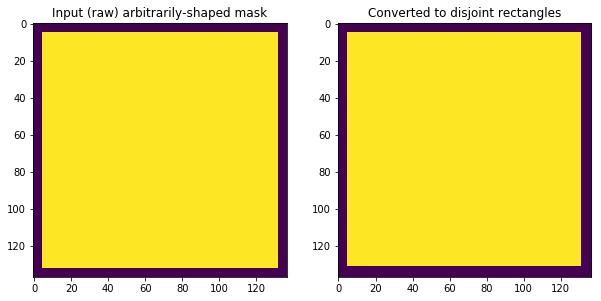

number of masked regions: 1


In [2]:
# msk_path = '../examples/places2/case1_mask.png'
# img_path = '../examples/places2/case1_raw.png'
# img_path = '../examples/test/circle.png'
img_path = '../examples/test/plane.png'

mask = None # init.load_mask(path=msk_path, convert=True)
image = init.load_grayscale_image(img_path)

# Pad image to a square so ACID grid size can be upscaled
h, w = image.shape
if h > w:
    temp = np.ones((h, h))*255
    temp[:, :w] = image
    image = temp
else:
    temp = np.ones((w, w))*255
    temp[:h, :] = image
    image = temp

if mask is not None:
    temp = np.zeros(image.shape)
    if h > w:
        temp[:, :w] = mask
        mask = temp
    else:
        temp[:h, :] = mask
        mask = temp

mask = np.zeros_like(image)
mask[5:-5, 5:-5] = 1

print("New image shape is {}".format(image.shape))
print("New mask shape is {}".format(mask.shape))

regions = init._find_disjoint_masked_regions(mask)
# NOTE: Uncomment to visialize initial masked reigons
init.visualize_masked_regions(mask, regions)

regions = init.compute_masked_regions(image, mask)
print('number of masked regions:', len(regions))


## Initialize t-snakes
_Note: Length 17 t-snake (i.e. the sort one) is visibly wrong, not sure how we can fix that_
*Legend*
* Green lines: Normal vectors
* White Nodes: Initial 5 nodes of the snake
* Yellow Nodes: Final 5 nodes of the snake
    * This tells us which way the snake was initialized, Counter Clockwise or Clockwise

In [3]:
### Parameters for T-snakes ### 
N = image.shape[0]           # 30 nodes
p = 0.006        # scale for Eq (7)
c = 10.0         # scale for Eq (A.4)
a = 8.5          # tension param in Eq (8)
b = 16.0         # bending param in Eq (8)
q = 19.0         # scale for Eq (4)
gamma = 1.0      # friction param in Eq (8)
dt = 0.08        # step size in Eq (8)
sigma = 0.5      # gaussian filter param in Eq (A.4)
k = 0.5          # param k in Eq (6)

# region = compute_masked_regions(image, mask)[0]
# region.initialize_tsnake(N, p, c, sigma, a, b, q, gamma, dt)
# region.visualize()

# snake = region._initial_tsnake

tsnakes = []

for region in regions:
    tsnake = region.initialize_tsnake(
        N=N, p=p, c=c, sigma=sigma, a=a, b=b, q=q, gamma=gamma,
        dt=dt
    )
    tsnakes.append(tsnake)
#     region.visualize() # NOTE: To show tsnakes on images, uncomment

# tsnakes.sort(key=lambda t: len(t.nodes))
t_snake_lengths = [len(t.nodes) for t in tsnakes]
print('Length of T-Snakes initialized on image:\n{}'.format(t_snake_lengths))

Length of T-Snakes initialized on image:
[167]


## Create Grid

In [4]:
# image = init.load_grayscale_image(img_path)
xdim, ydim = image.shape
scale = np.gcd(xdim, ydim)
# scale /= 10
print('image shape: ', image.shape, '\nscale: ', scale)


image shape:  (137, 137) 
scale:  137


In [5]:
acid_grid = Grid(image=image, scale=scale)

# Update grid
# NOTE: Uncomment for force, expensive calculation, done locally in each masked region
# acid_grid.get_image_force(sigma=sigma, c=c, p=p)
# acid_grid.get_inflation_force(threshold=threshold)
acid_grid.gen_simplex_grid()
print('Simplex grid shape: {}'.format(acid_grid.grid.shape))


Simplex grid shape: (2, 2)


## Test snake evolution

In [6]:
iterations = 3
target_region = 3
M = 30
plot_grid = acid_grid # Uncomment and comment next line to plot ACID grid lines on image
# plot_grid = None


region = regions[target_region]
for i in tqdm(range(iterations)):
    region_snake = tsnakes[target_region]
    # Run:
    # 1) the m-step function (which has M deformation steps), and
    # 2) the reparameterization (occuring every M deformation steps)
    region.show_snake(snake=region_snake, grid=plot_grid, save_fig='reparam/iter{}.0.png'.format(i))
    
    print(len(region_snake.nodes))
    region_snake.m_step(M)
    region.show_snake(snake=region_snake, grid=plot_grid, save_fig='reparam/iter{}.1.png'.format(i))
    
    new_region_snakes, grid_node_queue = acid_grid.reparameterize_phase_one([region_snake])
    tsnakes[target_region] = new_region_snakes[0]
    region.show_snake(snake=tsnakes[target_region], grid=plot_grid, save_fig='reparam/iter{}.2.png'.format(i))
    print(len(new_region_snakes[0].nodes))
    

IndexError: list index out of range

## Test Intersection Computation

In [ ]:
print('shape of tsnakes:', np.shape(tsnakes))

# Compute snake intersections with grid
intersections = acid_grid.get_snake_intersections(tsnakes)
print('intersections shape:', np.shape(intersections))

n_inter_for_each_t_snake = [len(inter) for inter in intersections]
print('num of intersections for each t-snake:', n_inter_for_each_t_snake)
